# 2D-CNN pipeline (images ready)

In [ ]:
# ====== Imports ======
import os, random
import numpy as np
import pandas as pd
from scipy.stats import iqr
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# ====== Colab drive mount ======
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ====== Paths ======
IMG_DIR = "/content/drive/MyDrive/Colab Notebooks/GADF_train_65x65"
CSV_PATH = "/content/train_df_averaged.csv"

TARGETS = ['Moi','NDF',  'Starch']
IMG_SIZE = 65 #------------------------------------------>16

In [ ]:
# ====== Hyperparams ======
batch_size = 128
epochs = 200
lr = 0.0001
n_splits = 5
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
# ====== Load CSV ======
df = pd.read_csv(CSV_PATH)
# df = df.groupby('Sample ID').mean() # If the data is not averaged
# df = df.dropna(subset=TARGETS).reset_index(drop=True)
print("Data shape:", df.shape)

Data shape: (784, 261)


In [ ]:
# ====== Scale targets ======
from sklearn.preprocessing import StandardScaler
# y_scaler = MinMaxScaler()
y_scaler = StandardScaler() # => Auto scale
targets_scaled = y_scaler.fit_transform(df[TARGETS].values.astype(np.float32))

In [ ]:
plot_name = "sample"  # Change this based on the plot type

In [ ]:
# ====== Dataset class (images already ready) ======

class SoilImageDataset(Dataset):
    def __init__(self, df, img_dir, targets_scaled, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.targets = targets_scaled.astype(np.float32)
        self.transform = transform if transform else transforms.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"{plot_name}_{idx}.png")
        img = Image.open(img_path).convert("L").resize((IMG_SIZE, IMG_SIZE))  # grayscale
        img = self.transform(img)  # shape (1,H,W)
        target = torch.from_numpy(self.targets[idx])
        return img, target

transform = transforms.Compose([
    transforms.ToTensor(),  # (H,W) -> (1,H,W), float in [0,1]
])

dataset = SoilImageDataset(df, IMG_DIR, targets_scaled, transform=transform)
print("Dataset length:", len(dataset))

Dataset length: 784


In [ ]:
# ====== CNN model (as in Table 2) ======
class CNN2D(nn.Module):
    def __init__(self, in_channels=1, num_outputs=3): # Changed num_outputs to 3
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)
        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5a = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5b = nn.Conv2d(512, 512, 3, padding=1)

        self.flattened = 512 * 2 * 2
        self.fc1 = nn.Linear(self.flattened, 128)
        self.fc2 = nn.Linear(128, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x)); x = self.pool(x)
        x = self.relu(self.conv2(x)); x = self.pool(x)
        x = self.relu(self.conv3a(x)); x = self.relu(self.conv3b(x)); x = self.pool(x)
        x = self.relu(self.conv4a(x)); x = self.relu(self.conv4b(x)); x = self.pool(x)
        x = self.relu(self.conv5a(x)); x = self.relu(self.conv5b(x)); x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
# ====== Metrics ======
def compute_metrics_orig(y_true, y_pred):
    results = []
    for i in range(y_true.shape[1]):
        yt, yp = y_true[:, i], y_pred[:, i]
        rmse = np.sqrt(mean_squared_error(yt, yp))
        r2 = r2_score(yt, yp)
        rpiq = float(iqr(yt) / rmse) if rmse > 1e-8 else float("inf")
        results.append({"RMSE": rmse, "R2": r2, "RPIQ": rpiq})
    return results

In [ ]:
# ====== Split train/test ======
indices = np.arange(len(dataset))
trainval_idx, test_idx = train_test_split(indices, test_size=0.25, random_state=seed)

In [ ]:
# ====== 5-Fold CV ====== But more Verbose
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
for fold, (t_idx, v_idx) in enumerate(kf.split(trainval_idx)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")
    train_loader = DataLoader(Subset(dataset, trainval_idx[t_idx]), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(Subset(dataset, trainval_idx[v_idx]), batch_size=batch_size, shuffle=False)

    model = CNN2D().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        # Verbose mode
        if (epoch+1) % 1 == 0:  # This will print every epoch (verbose=2 equivalent in training)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    # Validation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb.to(device)).cpu().numpy()
            yb_np = yb.cpu().numpy()
            preds_orig = y_scaler.inverse_transform(preds)
            yb_orig = y_scaler.inverse_transform(yb_np)
            y_true.append(yb_orig); y_pred.append(preds_orig)
    y_true, y_pred = np.vstack(y_true), np.vstack(y_pred)

    # Compute and print metrics
    metrics = compute_metrics_orig(y_true, y_pred)
    for i, t in enumerate(TARGETS):
        print(f"{t}: RMSE={metrics[i]['RMSE']:.3f}, R2={metrics[i]['R2']:.3f}, RPIQ={metrics[i]['RPIQ']:.3f}")



--- Fold 1/5 ---
Epoch 1/200, Loss: 0.8653
Epoch 2/200, Loss: 1.1220
Epoch 3/200, Loss: 0.7942
Epoch 4/200, Loss: 0.8999
Epoch 5/200, Loss: 1.1024
Epoch 6/200, Loss: 1.0890
Epoch 7/200, Loss: 1.1732
Epoch 8/200, Loss: 0.8739
Epoch 9/200, Loss: 1.3572
Epoch 10/200, Loss: 0.8861
Epoch 11/200, Loss: 0.9389
Epoch 12/200, Loss: 1.2958
Epoch 13/200, Loss: 0.9829
Epoch 14/200, Loss: 1.0446
Epoch 15/200, Loss: 1.1082
Epoch 16/200, Loss: 1.3124
Epoch 17/200, Loss: 0.8055
Epoch 18/200, Loss: 1.0464
Epoch 19/200, Loss: 0.8735
Epoch 20/200, Loss: 1.0922
Epoch 21/200, Loss: 0.8988
Epoch 22/200, Loss: 0.8768
Epoch 23/200, Loss: 1.0907
Epoch 24/200, Loss: 1.2095
Epoch 25/200, Loss: 0.7821
Epoch 26/200, Loss: 0.7865
Epoch 27/200, Loss: 0.7198
Epoch 28/200, Loss: 0.6637
Epoch 29/200, Loss: 1.1671
Epoch 30/200, Loss: 0.8208
Epoch 31/200, Loss: 0.7721
Epoch 32/200, Loss: 0.5975
Epoch 33/200, Loss: 0.9000
Epoch 34/200, Loss: 0.7503
Epoch 35/200, Loss: 0.6800
Epoch 36/200, Loss: 0.5699
Epoch 37/200, Loss:

In [ ]:
# ====== Calculate mean of the metrics obtained in each fold in CV ======

# Lists to store metrics for each fold
all_fold_metrics = {target: {"RMSE": [], "R2": [], "RPIQ": []} for target in TARGETS}

# ... (rest of the code from the previous cell for the CV loop)
# After computing metrics for each fold:
for i, t in enumerate(TARGETS):
     print(f"{t}: RMSE={metrics[i]['RMSE']:.3f}, R2={metrics[i]['R2']:.3f}, RPIQ={metrics[i]['RPIQ']:.3f}")
     all_fold_metrics[t]["RMSE"].append(metrics[i]["RMSE"])
     all_fold_metrics[t]["R2"].append(metrics[i]["R2"])
     all_fold_metrics[t]["RPIQ"].append(metrics[i]["RPIQ"])


Moi: RMSE=2.521, R2=0.843, RPIQ=2.823
NDF: RMSE=3.936, R2=0.635, RPIQ=1.779
Starch: RMSE=6.286, R2=0.664, RPIQ=1.635


In [ ]:
# ====== Train final on all trainval + test evaluation ======
# Create data loaders for training and testing
final_loader = DataLoader(Subset(dataset, trainval_idx), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Subset(dataset, test_idx), batch_size=batch_size, shuffle=False)

# Initialize the model, optimizer, and loss function
final_model = CNN2D().to(device)  # Move model to the specified device (GPU or CPU)
optimizer = torch.optim.Adam(final_model.parameters(), lr=lr)  # Adam optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for regression tasks

# Start training for a specified number of epochs
for epoch in range(epochs):
    final_model.train()  # Set the model to training mode (enables dropout, batchnorm, etc.)

    # Initialize variables to track loss during this epoch
    epoch_loss = 0.0  # Track cumulative loss for the current epoch

    # Iterate over the batches in the training dataset
    for xb, yb in final_loader:
        xb, yb = xb.to(device), yb.to(device)  # Move data to the specified device (GPU or CPU)

        optimizer.zero_grad()  # Clear the previous gradients
        loss = criterion(final_model(xb), yb)  # Compute the loss for this batch
        loss.backward()  # Backpropagate the gradients
        optimizer.step()  # Update the model's parameters

        epoch_loss += loss.item()  # Accumulate loss for this batch

    # Print progress after each epoch
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss / len(final_loader):.4f}")

# Evaluate the model on the test dataset
final_model.eval()  # Set the model to evaluation mode (disables dropout, batchnorm)
y_true, y_pred = [], []  # Initialize lists to store true and predicted values

with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in test_loader:
        preds = final_model(xb.to(device)).cpu().numpy()  # Get predictions from the model
        yb_np = yb.cpu().numpy()  # Get true values from the batch

        # Reverse scaling (if applicable) to get the original values
        preds_orig = y_scaler.inverse_transform(preds)
        yb_orig = y_scaler.inverse_transform(yb_np)

        y_true.append(yb_orig)  # Append true values to the list
        y_pred.append(preds_orig)  # Append predicted values to the list

# Convert the lists to numpy arrays for metric computation
y_true, y_pred = np.vstack(y_true), np.vstack(y_pred)

# Compute the evaluation metrics (RMSE, R2, RPIQ) for the test set
test_metrics = compute_metrics_orig(y_true, y_pred)

# Print the metrics for each target
print("\n== Test metrics ==")
for i, t in enumerate(TARGETS):
    print(f"{t}: RMSE={test_metrics[i]['RMSE']:.3f}, R2={test_metrics[i]['R2']:.3f}, RPIQ={test_metrics[i]['RPIQ']:.3f}")

# Save the trained model to a file with a dynamic name
file_path = f"/content/{plot_name}_images_ready.pth"
torch.save(final_model.state_dict(), file_path)  # Save the model's state dictionary
print(f"Saved model to {file_path}")


Epoch 1/200, Train Loss: 0.9501
Epoch 2/200, Train Loss: 0.9931
Epoch 3/200, Train Loss: 0.9539
Epoch 4/200, Train Loss: 0.9548
Epoch 5/200, Train Loss: 0.9680
Epoch 6/200, Train Loss: 0.9421
Epoch 7/200, Train Loss: 0.9528
Epoch 8/200, Train Loss: 0.9794
Epoch 9/200, Train Loss: 0.9536
Epoch 10/200, Train Loss: 0.9628
Epoch 11/200, Train Loss: 0.9856
Epoch 12/200, Train Loss: 0.9946
Epoch 13/200, Train Loss: 0.9828
Epoch 14/200, Train Loss: 0.9742
Epoch 15/200, Train Loss: 0.9590
Epoch 16/200, Train Loss: 0.9691
Epoch 17/200, Train Loss: 0.9539
Epoch 18/200, Train Loss: 0.9777
Epoch 19/200, Train Loss: 0.9179
Epoch 20/200, Train Loss: 0.9069
Epoch 21/200, Train Loss: 0.9421
Epoch 22/200, Train Loss: 1.0007
Epoch 23/200, Train Loss: 0.9437
Epoch 24/200, Train Loss: 0.9551
Epoch 25/200, Train Loss: 0.9608
Epoch 26/200, Train Loss: 0.9321
Epoch 27/200, Train Loss: 0.9189
Epoch 28/200, Train Loss: 0.8881
Epoch 29/200, Train Loss: 0.8431
Epoch 30/200, Train Loss: 0.8338
Epoch 31/200, Train

#NOW
## - Colored spider

In [ ]:
# ====== Paths ======
IMG_DIR = "/content/drive/MyDrive/Colab Notebooks/spider_plots"
CSV_PATH = "/content/train_df_averaged.csv"

TARGETS = ['Moi','NDF',  'Starch']
IMG_SIZE = 65 #------------------------------------------>16

In [ ]:
# ====== Hyperparams ======
batch_size = 128
epochs = 200
lr = 0.0001
n_splits = 5
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
# ====== Load CSV ======
df = pd.read_csv(CSV_PATH)
# df = df.groupby('Sample ID').mean() # If the data is not averaged
# df = df.dropna(subset=TARGETS).reset_index(drop=True)
print("Data shape:", df.shape)

Data shape: (784, 261)


In [ ]:
# ====== Scale targets ======
from sklearn.preprocessing import StandardScaler
# y_scaler = MinMaxScaler()
y_scaler = StandardScaler() # => Auto scale
targets_scaled = y_scaler.fit_transform(df[TARGETS].values.astype(np.float32))

In [ ]:
plot_name = "spider_plot"  # Change this based on the plot type

In [ ]:
# ====== Dataset class (images already ready) ======

class SoilImageDataset(Dataset):
    def __init__(self, df, img_dir, targets_scaled, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.targets = targets_scaled.astype(np.float32)
        self.transform = transform if transform else transforms.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"{plot_name}_{idx}.png")
        img = Image.open(img_path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))  # grayscale
        img = self.transform(img)  # shape (1,H,W)
        target = torch.from_numpy(self.targets[idx])
        return img, target

transform = transforms.Compose([
    transforms.ToTensor(),  # (H,W) -> (1,H,W), float in [0,1]
])

dataset = SoilImageDataset(df, IMG_DIR, targets_scaled, transform=transform)
print("Dataset length:", len(dataset))

Dataset length: 784


In [ ]:
# ====== CNN model (as in Table 2) ======
class CNN2D(nn.Module):
    def __init__(self, in_channels=3, num_outputs=3): # Changed num_outputs to 3
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)
        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5a = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5b = nn.Conv2d(512, 512, 3, padding=1)

        self.flattened = 512 * 2 * 2
        self.fc1 = nn.Linear(self.flattened, 128)
        self.fc2 = nn.Linear(128, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x)); x = self.pool(x)
        x = self.relu(self.conv2(x)); x = self.pool(x)
        x = self.relu(self.conv3a(x)); x = self.relu(self.conv3b(x)); x = self.pool(x)
        x = self.relu(self.conv4a(x)); x = self.relu(self.conv4b(x)); x = self.pool(x)
        x = self.relu(self.conv5a(x)); x = self.relu(self.conv5b(x)); x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
# ====== Metrics ======
def compute_metrics_orig(y_true, y_pred):
    results = []
    for i in range(y_true.shape[1]):
        yt, yp = y_true[:, i], y_pred[:, i]
        rmse = np.sqrt(mean_squared_error(yt, yp))
        r2 = r2_score(yt, yp)
        rpiq = float(iqr(yt) / rmse) if rmse > 1e-8 else float("inf")
        results.append({"RMSE": rmse, "R2": r2, "RPIQ": rpiq})
    return results

In [ ]:
# ====== Split train/test ======
indices = np.arange(len(dataset))
trainval_idx, test_idx = train_test_split(indices, test_size=0.25, random_state=seed)

In [ ]:
# ====== 5-Fold CV ====== But more Verbose
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
for fold, (t_idx, v_idx) in enumerate(kf.split(trainval_idx)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")
    train_loader = DataLoader(Subset(dataset, trainval_idx[t_idx]), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(Subset(dataset, trainval_idx[v_idx]), batch_size=batch_size, shuffle=False)

    model = CNN2D().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        # Verbose mode
        if (epoch+1) % 1 == 0:  # This will print every epoch (verbose=2 equivalent in training)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    # Validation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb.to(device)).cpu().numpy()
            yb_np = yb.cpu().numpy()
            preds_orig = y_scaler.inverse_transform(preds)
            yb_orig = y_scaler.inverse_transform(yb_np)
            y_true.append(yb_orig); y_pred.append(preds_orig)
    y_true, y_pred = np.vstack(y_true), np.vstack(y_pred)

    # Compute and print metrics
    metrics = compute_metrics_orig(y_true, y_pred)
    for i, t in enumerate(TARGETS):
        print(f"{t}: RMSE={metrics[i]['RMSE']:.3f}, R2={metrics[i]['R2']:.3f}, RPIQ={metrics[i]['RPIQ']:.3f}")



--- Fold 1/5 ---
Epoch 1/200, Loss: 0.8241
Epoch 2/200, Loss: 0.9547
Epoch 3/200, Loss: 1.0900
Epoch 4/200, Loss: 0.8609
Epoch 5/200, Loss: 0.8625
Epoch 6/200, Loss: 0.9531
Epoch 7/200, Loss: 0.7620
Epoch 8/200, Loss: 1.2543
Epoch 9/200, Loss: 0.9104
Epoch 10/200, Loss: 0.9074
Epoch 11/200, Loss: 0.8870
Epoch 12/200, Loss: 1.2901
Epoch 13/200, Loss: 0.9223
Epoch 14/200, Loss: 0.9645
Epoch 15/200, Loss: 0.8196
Epoch 16/200, Loss: 1.0149
Epoch 17/200, Loss: 0.9574
Epoch 18/200, Loss: 0.8710
Epoch 19/200, Loss: 0.9852
Epoch 20/200, Loss: 1.0284
Epoch 21/200, Loss: 0.7804
Epoch 22/200, Loss: 0.9370
Epoch 23/200, Loss: 0.8378
Epoch 24/200, Loss: 0.7649
Epoch 25/200, Loss: 1.0858
Epoch 26/200, Loss: 0.7759
Epoch 27/200, Loss: 0.7768
Epoch 28/200, Loss: 0.8657
Epoch 29/200, Loss: 0.8290
Epoch 30/200, Loss: 0.8819
Epoch 31/200, Loss: 0.5457
Epoch 32/200, Loss: 0.7937
Epoch 33/200, Loss: 0.7700
Epoch 34/200, Loss: 0.8885
Epoch 35/200, Loss: 0.9520
Epoch 36/200, Loss: 0.7806
Epoch 37/200, Loss:

In [ ]:
# ====== Calculate mean of the metrics obtained in each fold in CV ======

# Lists to store metrics for each fold
all_fold_metrics = {target: {"RMSE": [], "R2": [], "RPIQ": []} for target in TARGETS}

# ... (rest of the code from the previous cell for the CV loop)
# After computing metrics for each fold:
for i, t in enumerate(TARGETS):
     print(f"{t}: RMSE={metrics[i]['RMSE']:.3f}, R2={metrics[i]['R2']:.3f}, RPIQ={metrics[i]['RPIQ']:.3f}")
     all_fold_metrics[t]["RMSE"].append(metrics[i]["RMSE"])
     all_fold_metrics[t]["R2"].append(metrics[i]["R2"])
     all_fold_metrics[t]["RPIQ"].append(metrics[i]["RPIQ"])


Moi: RMSE=2.960, R2=0.783, RPIQ=2.404
NDF: RMSE=4.221, R2=0.580, RPIQ=1.658
Starch: RMSE=7.062, R2=0.576, RPIQ=1.456


Epoch 1/200, Train Loss: 0.9689
Epoch 2/200, Train Loss: 0.9745
Epoch 3/200, Train Loss: 0.9888
Epoch 4/200, Train Loss: 0.9623
Epoch 5/200, Train Loss: 0.9631
Epoch 6/200, Train Loss: 0.9576
Epoch 7/200, Train Loss: 0.9789
Epoch 8/200, Train Loss: 0.9460
Epoch 9/200, Train Loss: 0.9712
Epoch 10/200, Train Loss: 0.9477
Epoch 11/200, Train Loss: 0.9738
Epoch 12/200, Train Loss: 0.9438
Epoch 13/200, Train Loss: 0.9297
Epoch 14/200, Train Loss: 0.8975
Epoch 15/200, Train Loss: 0.8794
Epoch 16/200, Train Loss: 0.8639
Epoch 17/200, Train Loss: 0.8667
Epoch 18/200, Train Loss: 0.8604
Epoch 19/200, Train Loss: 0.8383
Epoch 20/200, Train Loss: 0.8520
Epoch 21/200, Train Loss: 0.7949
Epoch 22/200, Train Loss: 0.8193
Epoch 23/200, Train Loss: 0.7893
Epoch 24/200, Train Loss: 0.7660
Epoch 25/200, Train Loss: 0.7502
Epoch 26/200, Train Loss: 0.6776
Epoch 27/200, Train Loss: 0.6854
Epoch 28/200, Train Loss: 0.6553
Epoch 29/200, Train Loss: 0.5949
Epoch 30/200, Train Loss: 0.5661
Epoch 31/200, Train

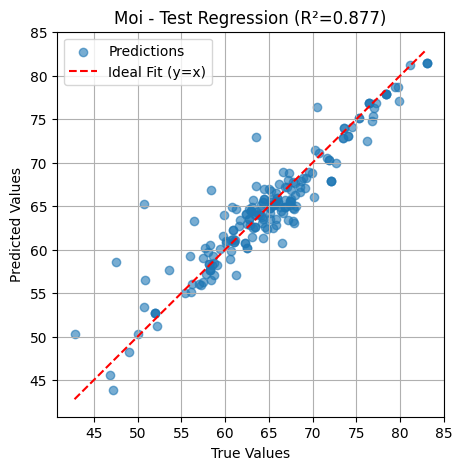

NDF: RMSE=3.470, R2=0.687, RPIQ=2.255


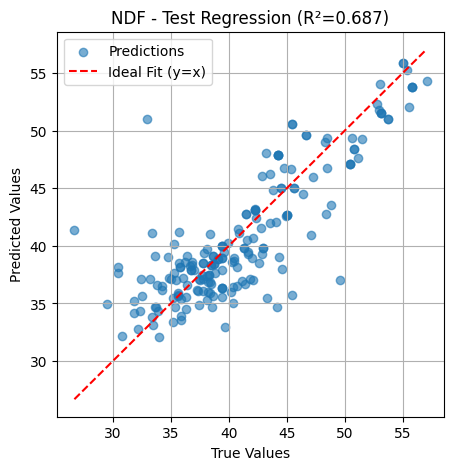

Starch: RMSE=4.703, R2=0.794, RPIQ=2.396


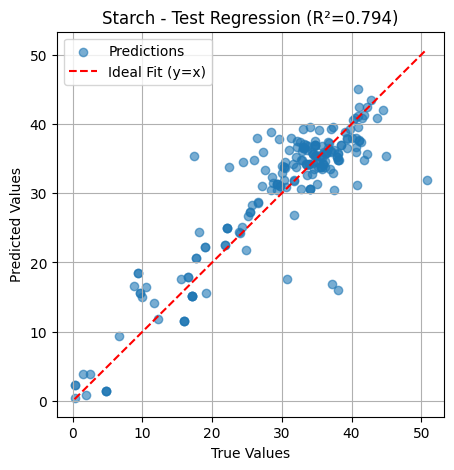

Saved model to /content/spider_plot_images_ready.pth


In [ ]:
import matplotlib.pyplot as plt

# ====== Train final on all trainval + test evaluation ======
final_loader = DataLoader(Subset(dataset, trainval_idx), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Subset(dataset, test_idx), batch_size=batch_size, shuffle=False)

final_model = CNN2D().to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in range(epochs):
    final_model.train()
    epoch_loss = 0.0
    for xb, yb in final_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(final_model(xb), yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss / len(final_loader):.4f}")

# ====== Evaluation ======
final_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        preds = final_model(xb.to(device)).cpu().numpy()
        yb_np = yb.cpu().numpy()
        preds_orig = y_scaler.inverse_transform(preds)
        yb_orig = y_scaler.inverse_transform(yb_np)
        y_true.append(yb_orig)
        y_pred.append(preds_orig)

y_true, y_pred = np.vstack(y_true), np.vstack(y_pred)

# ====== Metrics ======
test_metrics = compute_metrics_orig(y_true, y_pred)
print("\n== Test metrics ==")
for i, t in enumerate(TARGETS):
    print(f"{t}: RMSE={test_metrics[i]['RMSE']:.3f}, R2={test_metrics[i]['R2']:.3f}, RPIQ={test_metrics[i]['RPIQ']:.3f}")

    # ====== Plot regression curve ======
    plt.figure(figsize=(5,5))
    plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.6, label="Predictions")
    min_val, max_val = y_true[:, i].min(), y_true[:, i].max()
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit (y=x)")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{t} - Test Regression (R²={test_metrics[i]['R2']:.3f})")
    plt.legend()
    plt.grid(True)
    plt.show()

# ====== Save model ======
file_path = f"/content/{plot_name}_images_ready.pth"
torch.save(final_model.state_dict(), file_path)
print(f"Saved model to {file_path}")
